# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1z6Sgk9jKFEdVWFaK-X0iQY4nosTwCi1S?usp=sharing


In [ ]:
# html file
%%shell
jupyter nbconvert --to html "/content/Lab3_AnikaMule.ipynb"

[NbConvertApp] Converting notebook /content/Lab3_AnikaMule.ipynb to html
[NbConvertApp] Writing 1766200 bytes to /content/Lab3_AnikaMule.html


## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.datasets as datasets
import torchvision.transforms as transforms


In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


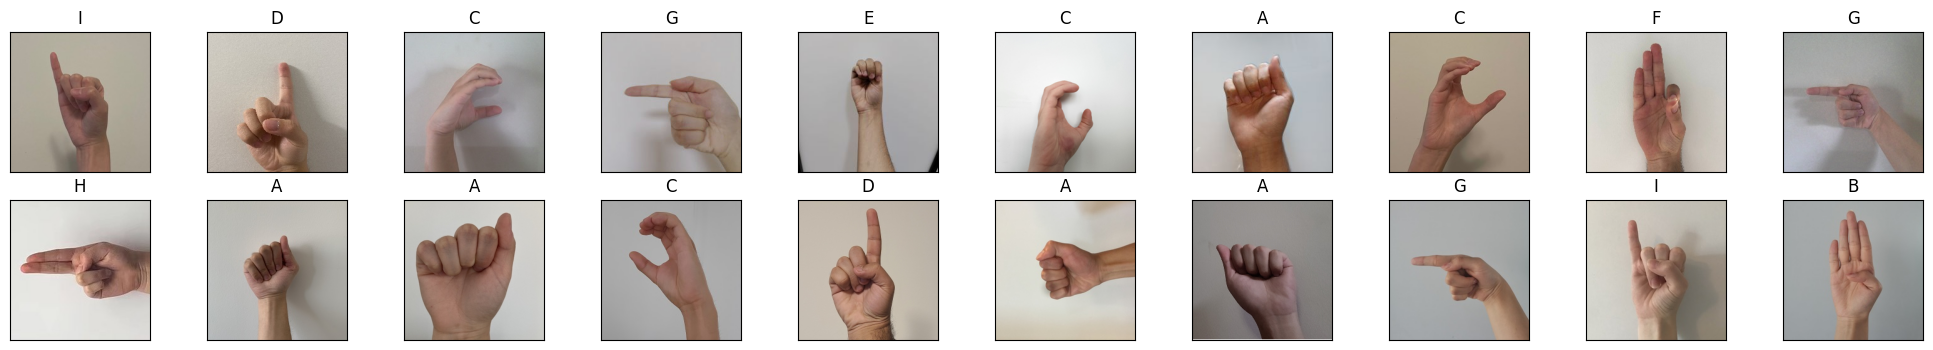

In [ ]:

# use GPU instead of CPU
use_cuda = True
# location on Google Drive
master_path = '/content/gdrive/My Drive/Lab3_Dataset/Lab3_Gestures_Summer'


# Transform Settings
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load all images from the specified directory
dataset = datasets.ImageFolder(master_path, transform=transform)

# use 60% training, 20% validation, 20% testing
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Prepare DataLoader
batch_size = 30
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Visualize some sample data
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

plt.show()

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
torch.manual_seed(10) # set the random seed
from math import floor

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "CNNClassifier"
        self.conv1 = nn.Conv2d(3, 5, 10)  # input channel, output channel, kernel size
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10, 20, 2)

        self.pool = nn.MaxPool2d(2, 2)

        # Computing into the Fully Connected Layer
        self.x = floor((224 - 10 + 1) / 2)
        self.y = floor((self.x - 5 + 1) / 2)
        self.z = floor((self.y - 2 + 1) / 2)
        self.fc = 20 * self.z * self.z

        self.fc1 = nn.Linear(self.fc, 32)  # Update input size accordingly
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Convolutional Layers: There are three convolutional layers with increasing channel sizes (5, 10, and 20). This helps in extracting progressively more complex features.

Pooling Layers: Max pooling is applied after each convolutional layer to reduce the spatial dimensions.

Fully Connected Layers: Two fully connected layers are used for classification. The final output layer has 9 units, corresponding to the 9 gesture classes (A-I).

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def generate_model_name(model_name, batch_sz, lr, ep):
    return f"model_{model_name}_batch{batch_sz}_lr{lr}_epoch{ep}"

def train(model, train_dataset, val_dataset, batch_size=128, num_epochs=20, learn_rate=0.001):
    torch.manual_seed(10)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)



    # training
    iter = 0
    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            optimizer.zero_grad()         # a clean up step for PyTorch
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            iter =+ 1

        # track accuracy
        train_acc[epoch] = calculate_accuracy(model, train_loader)
        val_acc[epoch] = calculate_accuracy(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}: Train acc: {train_acc[epoch]:.4f} | Validation acc: {val_acc[epoch]:.4f}")

        model_path = generate_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path) # saving model

    epochs = np.arange(1, num_epochs + 1)

    return train_acc, val_acc, epochs

def calculate_accuracy(model, loader):
    correct_predictions = 0
    total_samples = 0

    for images, targets in loader:
        if torch.cuda.is_available():
            images = images.cuda()
            targets = targets.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    return correct_predictions / total_samples


I chose cross entropy loss because its usually used for multi-class classification problems due to its overall high performance. I also chose the Adam optimizer since its a well performing optimizer that makes improvements on other optimizers such as SGD.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def overfit_to_small_dataset(cnn_model, small_train_loader, batch_sz=30, epochs=45, learning_rate=0.001):
    torch.manual_seed(10)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

    training_accuracy = []

    # Training loop
    iteration = 0
    for epoch in range(epochs):
        for images, labels in iter(small_train_loader):
          if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

            outputs = cnn_model(images)             # Forward pass
            loss = loss_function(outputs, labels)   # Compute the total loss
            loss.backward()                         # Backward pass (compute parameter updates)
            optimizer.step()                        # Update each parameter
            optimizer.zero_grad()                   # Clean up step for PyTorch
            iteration += 1

        # Track accuracy
        training_accuracy.append(calculate_accuracy(cnn_model, small_train_loader))
        print(f"Epoch: {epoch}, Training Accuracy: {training_accuracy[-1]}")

    return training_accuracy

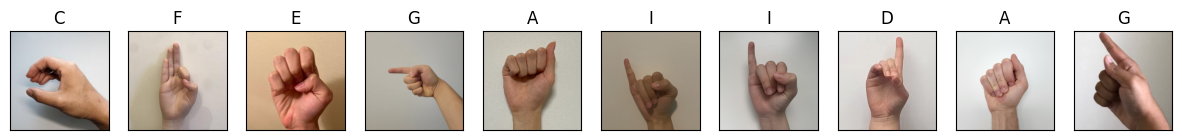

In [ ]:
from torch.utils.data import Subset, DataLoader

# Transform settings
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load all images from the specified directory
full_dataset = datasets.ImageFolder(master_path, transform=data_transform)

# Select 10 random indices for a small dataset
random_indices = np.random.choice(len(full_dataset), size=10, replace=False)
small_dataset = Subset(full_dataset, random_indices)

# Create DataLoader for the small dataset
mini_batch_size = 3
small_data_loader = torch.utils.data.DataLoader(small_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)

# Visualize some sample data
category_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# Obtain one batch of images
data_iter = iter(small_data_loader)
sample_images, sample_labels = next(data_iter)  # Use the built-in next() function
sample_images = sample_images.numpy()  # Convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 6))
for i in range(len(sample_images)):
    ax = fig.add_subplot(1, len(sample_images), i + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(sample_images[i], (1, 2, 0)))
    ax.set_title(category_names[sample_labels[i]])

plt.show()


In [ ]:
# Define the CNN model
CNN_model = CNNClassifier()

# Perform overfitting on the small dataset
overfit_to_small_dataset(CNN_model, small_data_loader)

Epoch: 0, Training Accuracy: 0.1
Epoch: 1, Training Accuracy: 0.1
Epoch: 2, Training Accuracy: 0.1
Epoch: 3, Training Accuracy: 0.1
Epoch: 4, Training Accuracy: 0.1
Epoch: 5, Training Accuracy: 0.1
Epoch: 6, Training Accuracy: 0.1
Epoch: 7, Training Accuracy: 0.1
Epoch: 8, Training Accuracy: 0.1
Epoch: 9, Training Accuracy: 0.1
Epoch: 10, Training Accuracy: 0.1
Epoch: 11, Training Accuracy: 0.1
Epoch: 12, Training Accuracy: 0.1
Epoch: 13, Training Accuracy: 0.1
Epoch: 14, Training Accuracy: 0.1
Epoch: 15, Training Accuracy: 0.1
Epoch: 16, Training Accuracy: 0.1
Epoch: 17, Training Accuracy: 0.1
Epoch: 18, Training Accuracy: 0.1
Epoch: 19, Training Accuracy: 0.1
Epoch: 20, Training Accuracy: 0.1
Epoch: 21, Training Accuracy: 0.1
Epoch: 22, Training Accuracy: 0.1
Epoch: 23, Training Accuracy: 0.1
Epoch: 24, Training Accuracy: 0.1
Epoch: 25, Training Accuracy: 0.1
Epoch: 26, Training Accuracy: 0.1
Epoch: 27, Training Accuracy: 0.1
Epoch: 28, Training Accuracy: 0.1
Epoch: 29, Training Accu

[0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1]

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
# 1. Learning rate
# 2. Kernel size in each convolutional layer
# 3. Batch size

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
def train_and_plot(model, train_dataset, val_dataset, batch_size, num_epochs, learn_rate):
    if torch.cuda.is_available():
        model.cuda()

    train_acc, val_acc, epochs = train(model, train_dataset, val_dataset, batch_size, num_epochs, learn_rate)

    # Plot the training accuracy
    plt.plot(epochs, train_acc)
    plt.title(f"Training Curve with Batch Size = {batch_size}, LR = {learn_rate}")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.show()

    # Plot the validation accuracy
    plt.plot(epochs, val_acc)
    plt.title(f"Validation Curve with Batch Size = {batch_size}, LR = {learn_rate}")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()


Epoch 1/20: Train acc: 0.1104 | Validation acc: 0.1219
Epoch 2/20: Train acc: 0.1578 | Validation acc: 0.1445
Epoch 3/20: Train acc: 0.1758 | Validation acc: 0.1941
Epoch 4/20: Train acc: 0.3456 | Validation acc: 0.3205
Epoch 5/20: Train acc: 0.5402 | Validation acc: 0.5034
Epoch 6/20: Train acc: 0.5868 | Validation acc: 0.5688
Epoch 7/20: Train acc: 0.6026 | Validation acc: 0.5666
Epoch 8/20: Train acc: 0.6304 | Validation acc: 0.5892
Epoch 9/20: Train acc: 0.6153 | Validation acc: 0.5643
Epoch 10/20: Train acc: 0.6754 | Validation acc: 0.6479
Epoch 11/20: Train acc: 0.6514 | Validation acc: 0.6027
Epoch 12/20: Train acc: 0.6544 | Validation acc: 0.6027
Epoch 13/20: Train acc: 0.6769 | Validation acc: 0.6366
Epoch 14/20: Train acc: 0.7198 | Validation acc: 0.6275
Epoch 15/20: Train acc: 0.7415 | Validation acc: 0.6614
Epoch 16/20: Train acc: 0.7265 | Validation acc: 0.6140
Epoch 17/20: Train acc: 0.7415 | Validation acc: 0.6433
Epoch 18/20: Train acc: 0.7611 | Validation acc: 0.6411
E

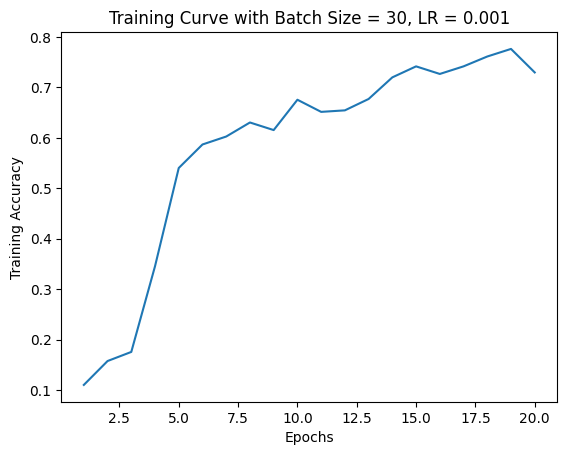

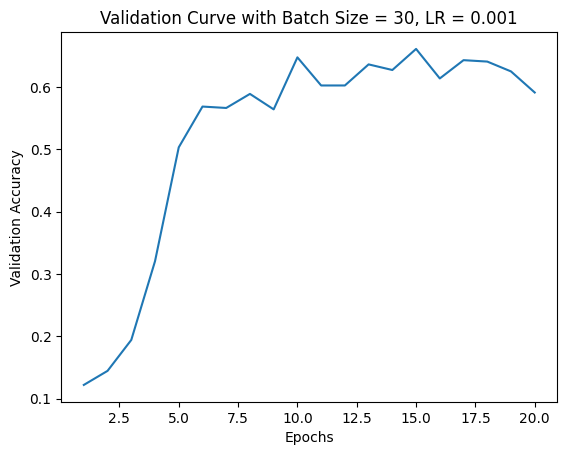

In [ ]:
# First training session
# batch_size = 30
# num_epochs = 20
# learn_rate = 0.001
# kernel sizes: 10, 5, 2
CNN_model = CNNClassifier()

# Train and plot with the specified parameters
train_and_plot(CNN_model, train_dataset, val_dataset, batch_size=30, num_epochs=20, learn_rate=0.001)

Epoch 1/15: Train acc: 0.2675 | Validation acc: 0.2348
Epoch 2/15: Train acc: 0.5702 | Validation acc: 0.5102
Epoch 3/15: Train acc: 0.6033 | Validation acc: 0.5485
Epoch 4/15: Train acc: 0.6551 | Validation acc: 0.5756
Epoch 5/15: Train acc: 0.6957 | Validation acc: 0.6366
Epoch 6/15: Train acc: 0.7596 | Validation acc: 0.6772
Epoch 7/15: Train acc: 0.7904 | Validation acc: 0.6975
Epoch 8/15: Train acc: 0.8129 | Validation acc: 0.7111
Epoch 9/15: Train acc: 0.8573 | Validation acc: 0.7178
Epoch 10/15: Train acc: 0.8159 | Validation acc: 0.6795
Epoch 11/15: Train acc: 0.8820 | Validation acc: 0.7201
Epoch 12/15: Train acc: 0.8963 | Validation acc: 0.7314
Epoch 13/15: Train acc: 0.9098 | Validation acc: 0.7336
Epoch 14/15: Train acc: 0.9174 | Validation acc: 0.7404
Epoch 15/15: Train acc: 0.9324 | Validation acc: 0.7720


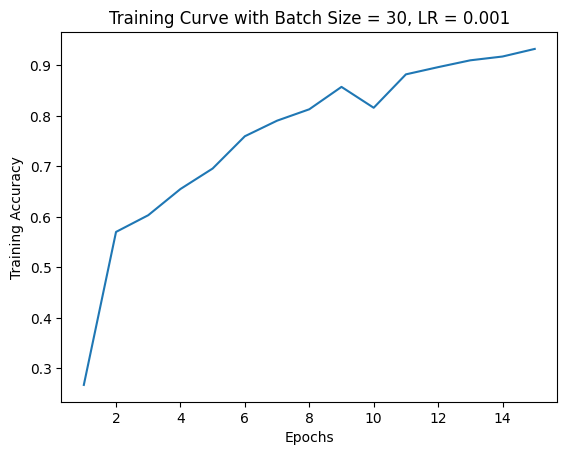

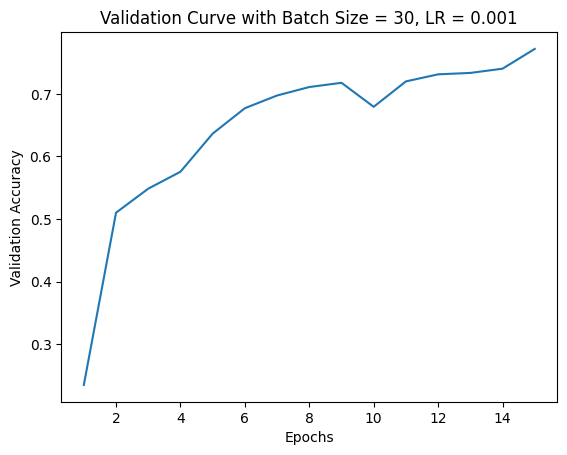

In [ ]:
# Second training session
# batch_size = 30
# num_epochs = 15
# learn_rate = 0.001
# kernel sizes: 2, 5, 10

# although I did not suggest tuning number of epochs, I am going to decrease it slightly to help with run time
# changed the kernel sizes so that it goes from small to larger sized kernels

class CNNKernelInverted(nn.Module):
    def __init__(self):
        super(CNNKernelInverted, self).__init__()
        self.name = "CNNKernelInverted"
        self.conv1 = nn.Conv2d(3, 5, 2)  # input channel, output channel, kernel size
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10, 20, 10)

        self.pool = nn.MaxPool2d(2, 2)

        self.x = floor((224 - 2 + 1) / 2)
        self.y = floor((self.x - 5 + 1) / 2)
        self.z = floor((self.y - 10 + 1) / 2)
        self.fc_size = 20 * self.z * self.z

        self.fc1 = nn.Linear(self.fc_size, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


CNN_new_model = CNNKernelInverted()

# Move model to GPU if available
if use_cuda and torch.cuda.is_available():
    CNN_new_model.cuda()

# Assuming train_and_plot function is defined elsewhere for training and validation
train_and_plot(CNN_new_model, train_dataset, val_dataset, batch_size=30, num_epochs=15, learn_rate=0.001)

Epoch 1/15: Train acc: 0.1165 | Validation acc: 0.1129
Epoch 2/15: Train acc: 0.2780 | Validation acc: 0.2325
Epoch 3/15: Train acc: 0.5004 | Validation acc: 0.4515
Epoch 4/15: Train acc: 0.5973 | Validation acc: 0.5395
Epoch 5/15: Train acc: 0.6687 | Validation acc: 0.6005
Epoch 6/15: Train acc: 0.6935 | Validation acc: 0.6411
Epoch 7/15: Train acc: 0.7295 | Validation acc: 0.6343
Epoch 8/15: Train acc: 0.7611 | Validation acc: 0.6817
Epoch 9/15: Train acc: 0.8084 | Validation acc: 0.6930
Epoch 10/15: Train acc: 0.8467 | Validation acc: 0.7178
Epoch 11/15: Train acc: 0.8655 | Validation acc: 0.7201
Epoch 12/15: Train acc: 0.8828 | Validation acc: 0.6998
Epoch 13/15: Train acc: 0.9174 | Validation acc: 0.7314
Epoch 14/15: Train acc: 0.9429 | Validation acc: 0.7652
Epoch 15/15: Train acc: 0.9579 | Validation acc: 0.7359


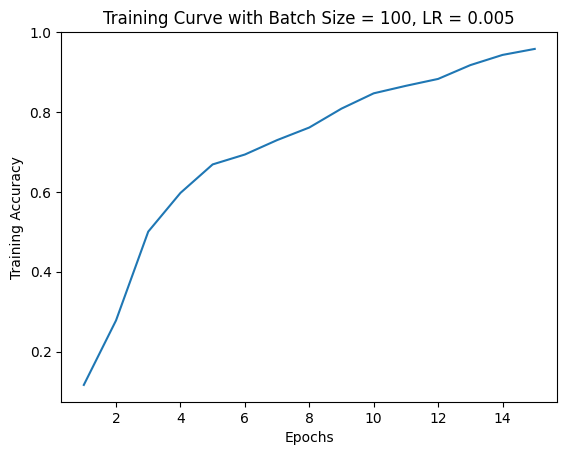

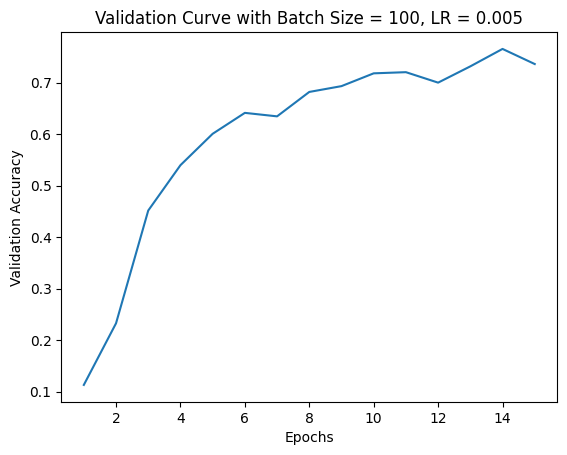

In [ ]:
# Third training session
# batch_size = 100
# num_epochs = 15
# learn_rate = 0.005
# kernel sizes: 10, 5, 2

# because the inverted kernal sizes (small to large) perfromed a little better, I will continue to use this
# I also chose to increase the batch size and learning rate

model_3 = CNNKernelInverted()

if use_cuda and torch.cuda.is_available():
    model_3.cuda()

# Train and plot with the specified parameters
train_and_plot(model_3, train_dataset, val_dataset, batch_size=100, num_epochs=15, learn_rate=0.005)

Epoch 1/15: Train acc: 0.3524 | Validation acc: 0.3093
Epoch 2/15: Train acc: 0.5462 | Validation acc: 0.4808
Epoch 3/15: Train acc: 0.5530 | Validation acc: 0.5102
Epoch 4/15: Train acc: 0.6123 | Validation acc: 0.5440
Epoch 5/15: Train acc: 0.6814 | Validation acc: 0.6050
Epoch 6/15: Train acc: 0.7115 | Validation acc: 0.6366
Epoch 7/15: Train acc: 0.7731 | Validation acc: 0.6524
Epoch 8/15: Train acc: 0.7791 | Validation acc: 0.6998
Epoch 9/15: Train acc: 0.7904 | Validation acc: 0.6524
Epoch 10/15: Train acc: 0.8542 | Validation acc: 0.7178
Epoch 11/15: Train acc: 0.8317 | Validation acc: 0.6817
Epoch 12/15: Train acc: 0.8911 | Validation acc: 0.7359
Epoch 13/15: Train acc: 0.8385 | Validation acc: 0.6885
Epoch 14/15: Train acc: 0.9241 | Validation acc: 0.7223
Epoch 15/15: Train acc: 0.9399 | Validation acc: 0.7472


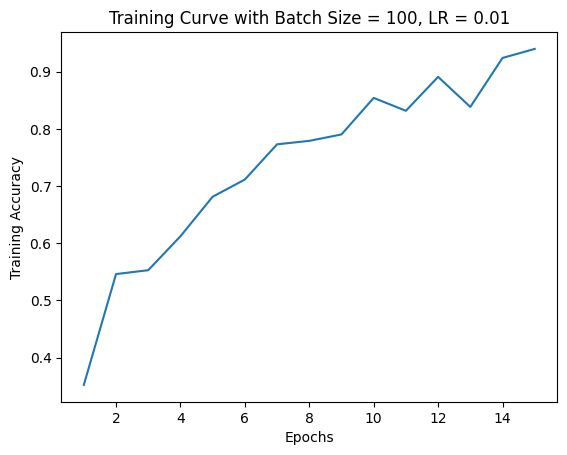

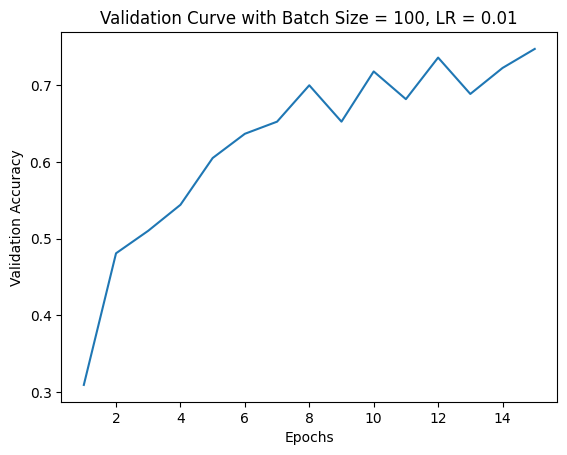

In [ ]:
# Fourth training session
# batch_size = 100
# num_epochs = 15
# learn_rate = 0.01
# kernel sizes: 10, 5, 2

# because the inverted kernel sizes (small to large) perfromed a little better, I will continue to use this
# because the validation curve didn't perform as well as in the secon training session,
    # I am going to keep the batch size the same, but increase the learning rate

model_4 = CNNKernelInverted()

if use_cuda and torch.cuda.is_available():
    model_4.cuda()

# Train and plot with the specified parameters
train_and_plot(model_4, train_dataset, val_dataset, batch_size=100, num_epochs=15, learn_rate=0.01)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The best training model out of the 4 I have trained is epoch 15 of training session 4 (the last training session. Because the training accuracy was 93.99% and the validation accuracy was 74.72%. Overall, this is the least over-fitted model amongst the 4 models.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
calculate_accuracy(model_4, test_loader)

0.7595505617977528

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 121MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# Save Features to Folder
import os
import torchvision.models
import torch

# Load AlexNet pretrained model
alexnet = torchvision.models.alexnet(pretrained=True)

# Define the base path on Google Drive
master_path = '/content/gdrive/My Drive/Lab3_Dataset/Lab3_Gestures_Summer'

# Example datasets (replace with your actual datasets)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

# List of classes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

def save_features(data_loader, phase, model, base_path, classes):
    counter = 0
    for images, labels in data_loader:
        # Extract features using AlexNet
        features = model.features(images)
        features_tensor = features.detach().cpu()

        for i in range(images.size(0)):
            class_label = classes[labels[i]]
            directory = os.path.join(base_path, phase, class_label)

            # Create directory if it doesn't exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save the feature tensor
            file_name = os.path.join(directory, f'{counter}.tensor')
            torch.save(features_tensor[i], file_name)
            counter += 1

# Example usage for saving features to train, val, and test folders
save_features(train_dataloader, 'train', alexnet, master_path, classes)
save_features(val_dataloader, 'val', alexnet, master_path, classes)
save_features(test_dataloader, 'test', alexnet, master_path, classes)

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [ ]:
# Define the master path on Google Drive
master_path = '/content/gdrive/My Drive/Lab3_Dataset/Lab3_Gestures_Summer'

test_features = torchvision.datasets.DatasetFolder(master_path + '/test', loader=torch.load, extensions=('.tensor'))
train_features = torchvision.datasets.DatasetFolder(master_path + '/train', loader=torch.load, extensions=('.tensor'))
val_features = torchvision.datasets.DatasetFolder(master_path + '/val', loader=torch.load, extensions=('.tensor'))

# Prepare DataLoaders
train_feature_load = torch.utils.data.DataLoader(train_features, batch_size=32, num_workers=1, shuffle=True)
val_feature_load = torch.utils.data.DataLoader(val_features, batch_size=32, num_workers=1, shuffle=True)
test_feature_load = torch.utils.data.DataLoader(test_features, batch_size=32, num_workers=1, shuffle=True)

# Define the custom model that takes AlexNet features as input
torch.manual_seed(10)
from math import floor

class AlexNetFCCN(nn.Module):
    def __init__(self, name="AlexNetFCCN"):
        super(AlexNetFCCN, self).__init__()
        self.conv1 = nn.Conv2d(256, 512, 3)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the correct input size into the Fully Connected Layer
        self.x = floor((6 - 3 + 1) / 2)
        self.FC_input = 512 * self.x * self.x

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 9)

        self.name = name

    def forward(self, features):
        x = self.pool(F.relu(self.conv1(features)))
        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



The neural network has two convolutional layers with ReLU activation and max pooling to extract and downsample features effectively. It also has three fully-connected layers: 512 units, 256 units, and 9 units for classification. This design balances feature extraction and classification accuracy while leveraging standard deep learning principles for efficient training and inference.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

Epoch 1/20: Train acc: 0.7658 | Validation acc: 0.7085
Epoch 2/20: Train acc: 0.8448 | Validation acc: 0.7842
Epoch 3/20: Train acc: 0.8641 | Validation acc: 0.8112
Epoch 4/20: Train acc: 0.9470 | Validation acc: 0.8817
Epoch 5/20: Train acc: 0.9763 | Validation acc: 0.9066
Epoch 6/20: Train acc: 0.9849 | Validation acc: 0.9098
Epoch 7/20: Train acc: 0.9886 | Validation acc: 0.9284
Epoch 8/20: Train acc: 0.9902 | Validation acc: 0.9398
Epoch 9/20: Train acc: 0.9902 | Validation acc: 0.9336
Epoch 10/20: Train acc: 0.9913 | Validation acc: 0.9315
Epoch 11/20: Train acc: 0.9927 | Validation acc: 0.9346
Epoch 12/20: Train acc: 0.9936 | Validation acc: 0.9336
Epoch 13/20: Train acc: 0.9936 | Validation acc: 0.9378
Epoch 14/20: Train acc: 0.9936 | Validation acc: 0.9398
Epoch 15/20: Train acc: 0.9936 | Validation acc: 0.9398
Epoch 16/20: Train acc: 0.9936 | Validation acc: 0.9378
Epoch 17/20: Train acc: 0.9936 | Validation acc: 0.9398
Epoch 18/20: Train acc: 0.9936 | Validation acc: 0.9398
E

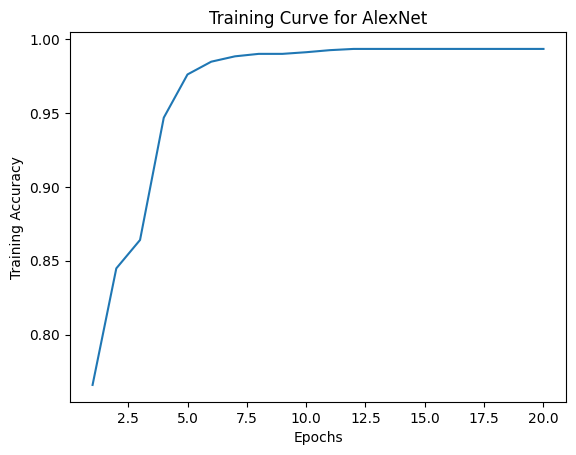

Text(0, 0.5, 'Validation Accuracy')

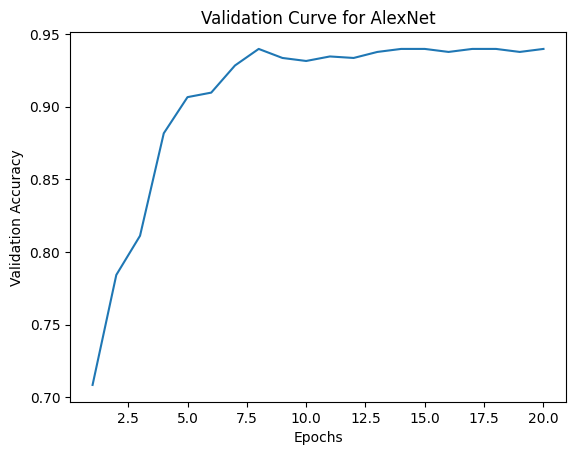

In [ ]:
#tensor = torch.from_numpy(tensor.detach().numpy())

alex_net = AlexNetFCCN()
if use_cuda and torch.cuda.is_available():
  alex_net.cuda()

train_acc, val_acc, epochs = train(alex_net, train_features, val_features)

plt.plot(epochs, train_acc)
plt.title("Training Curve for AlexNet")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve for AlexNet")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
calculate_accuracy(alex_net, test_feature_load)

0.963226571767497

The test accuracy of the AlexNet model is 96.32% which is a lot higher than the accuracy of my best model after training (model 4, or the last trained model) with an accuracy of 75.96%.

This shows that AlexNet's features are better than the features of my original trained network. Overall, AlexNet classifier neural network perfromed much better on the test data than my original trained network.